# Improving the Classifier

In this notebook, we continue from the work of our previous notebook, Simple Digits Classifier, and explore avenues to improve the accuracy of our classifier. To begin, we need to import from the Python libraries we'll be using in this notebook. Our imports are the exact same as the previous notebook.


In [1]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

# scikit-learn imports
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

c:\Users\jonta\anaconda3\envs\digits-classifier\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


We'll put the code from the previous notebook here in the following code block. If you're unfamiliar with this code, please revisit the previous notebook. We'll put the code into different functions so that we can quickly and concisely access this functionality. In particular, we have:
* `SimpleNN`: our neural network class. The constructor for this class now takes two arguments: `input_size`, the number of pixels in the input, and `num_neurons`, the number of neurons in both hidden layers.
* `create_simple_nn(input_size, num_neurons)`: a function which returns an instance of `SimpleNN`. We can call this function to create our neural network. It takes `input_size` and `num_neurons` as arguments.
* `train_model(net, trainloader, criterion, optimizer)`: this function trains our neural network, which passed as the first argument `net`. We also need to pass it the training data `trainloader`, the cost function `criterion`, and the optimizer algorithm `optimizer`. For simplicity, the function will always train the network for 200 epochs.
* `visualize_weight_matrices(net)`: plots the weight matrices for the second hidden layer and the output layer, as we saw in the previous notebook. We pass the function the network `net` as its only argument.
* `calculate_accuracy(net, testloader)`: a function which returns the accuracy of the network `net` on the test data `testloader`.
* `visualize_network_activations(net, dataloader)`: a function that visualizes each node's activation values. We take the first image supplied by `dataloader` and run it through `net`. The visualization includes the input image, the activation values, the predicted label, and the actual label.
* `plot_confusion_matrix(net, testloader)`: plots the confusion matrix for the network `net` on the test data `testloader`.

Again, most of this code should be familiar to you. We've organized the code into reusable functions. The only modifications we have made are to make the code more generalized, adding variables here and there. We'll use these functions multiple times as we explore different approaches to improving our neural network, greatly enhancing the readability of the code to come.

In [2]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_neurons):
        super(SimpleNN, self).__init__()
        self.input_size = input_size

        # The first hidden layer, with `input_size` inputs and `num_neurons` outputs
        self.fc1 = nn.Linear(input_size, num_neurons)

        # Use ReLU as the activation function of the first hidden layer
        self.relu1 = nn.ReLU()

        # The second hidden layer, with `num_neurons` inputs and `num_neurons` outputs
        self.fc2 = nn.Linear(num_neurons, num_neurons)

        # Use ReLU as the activation function of the second hidden layer
        self.relu2 = nn.ReLU()

        # The output layer, with `num_neurons` inputs and 10 outputs
        self.fc3 = nn.Linear(num_neurons, 10)

    def forward(self, x):
        # The input layer, flattening the input tensor into a 64-dimensional vector
        x = x.view(-1, self.input_size)

        # Run `x` through the first hidden layer, using the ReLU activation function
        x = self.relu1(self.fc1(x))

        # Run `x` through the second hidden layer, using the ReLU activation function
        x = self.relu2(self.fc2(x))

        # Run `x` through the output layer (note no activation function)
        x = self.fc3(x)

        return x


# Define a function to construct a simple neural network.
# The number of input features is given by `input_size` and the number of neurons in
# each hidden layer is given by `num_neurons`.
def create_simple_nn(input_size, num_neurons):
    return SimpleNN(input_size, num_neurons)


# Define a function to train a neural network, given by `net`.
# The training data is supplied by `trainloader`. The loss (cost) function is given by
# `criterion` and the optimizer is given by `optimizer`. This function returns an array
# of the training losses per epoch.
def train_model(net, trainloader, criterion, optimizer):
    # Keep a record of the average loss value after each epoch
    losses = []

    # Train the model for 200 epochs
    for epoch in range(200):
        # An accumulator to keep track of the loss values in this epoch
        running_loss = 0.0

        # Using the DataLoader, we can loop through batches of training data
        # `i` is the batch number, and `data` is the batch of training images
        for i, data in enumerate(trainloader):
            # Get the training inputs and target labels for the batch
            inputs, labels = data

            # Zero the parameter gradients, because each training batch should be indepently calculated
            # This step may be omitted in more complex neural network algorithms
            optimizer.zero_grad()

            # Push the input images through the network and obtain the predicted labels
            outputs = net(inputs.float())

            # Calculate the loss value based on the predicted labels and the target labels
            loss = criterion(outputs, F.one_hot(labels.long(), num_classes=10).float())

            # Propogate the loss backwards; i.e. perform backpropogation
            # This function call calculates the gradients for the entire network!
            loss.backward()

            # Updates the weights using SGD; i.e. perform gradient descent
            # This function call updates all the trainable parameters of the model, based on the gradient calculated in the previous step
            optimizer.step()

            # Keep track of the loss value for this batch
            running_loss += loss.item()

        # Once the epoch terminated, record the average loss for the epoch
        losses.append(running_loss / len(trainloader))

    return losses


# Define a function to visualize the weight matrices of the two last layers of the
# neural network, given by `net`.
def visualize_weight_matrices(net):
    weights_fc2 = net.fc2.weight.data.numpy()
    weights_fc3 = net.fc3.weight.data.numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cax2 = axs[0].matshow(weights_fc2, cmap="RdBu_r")
    fig.colorbar(cax2, ax=axs[0])
    axs[0].set_title("2nd Hidden Layer Weight Matrix")
    cax3 = axs[1].matshow(weights_fc3, cmap="RdBu_r")
    fig.colorbar(cax3, ax=axs[1])
    axs[1].set_title("Output Layer Weight Matrix")
    plt.tight_layout()
    plt.show()


# Define a function to calculate the accuracy of a neural network, given by `net`.
# The test data is supplied by `testloader`. This function returns the network's
# accuracy, as a percentage.
def calculate_accuracy(net, testloader):
    # To calculate accuracy, we divide the number of correct prediction by the total number of images
    correct = 0
    total = 0

    # We don't need to touch the gradient during evaluation
    with torch.no_grad():
        # Loop through each batch in the test set
        for data in testloader:
            # Get the test inputs and target labels for the batch
            images, labels = data

            # Push the input images through the network and obtain the predicted labels
            outputs = net(images.float())

            # The output is a one-hot vector, so we want to get the index of the highest value
            predicted = torch.argmax(outputs.data, 1)

            # Increment accumulator keeping track of the number of images and correct prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total * 100


# Define a function visualize the activation values of the nodes in the neural network,
# given by `net`.
# The data is supplied by `dataloader`. We just visualize the activations for the first
# image in the data set.
def visualize_network_activations(net, dataloader):
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()

        return hook

    net.relu1.register_forward_hook(get_activation("layer1"))
    net.relu2.register_forward_hook(get_activation("layer2"))
    net.fc3.register_forward_hook(get_activation("output"))

    input_image, label = next(iter(dataloader))
    input_image = input_image[0]
    label = label[0]

    predicted_output = net(input_image.float())
    predicted_label = torch.argmax(predicted_output).item()

    fig, axes = plt.subplots(1, 5, figsize=(15, 8))
    axes[0].imshow(input_image.squeeze().numpy(), cmap="gray_r")
    axes[0].set_title(f"Input Image (True label: {label.item()})", fontsize=16)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    activation_images = [activations["layer1"].numpy().T, activations["layer2"].numpy().T, activations["output"].numpy().T,]
    layer_names = ["Hidden Layer 1", "Hidden Layer 2", "Output Layer"]
    for i, activation in enumerate(activation_images):
        x, y = [0] * len(activation), list(range(len(activation) - 1, -1, -1))
        scatter = axes[i + 1].scatter(x, y, s=1000, c=activation, cmap="RdBu_r", edgecolors="k", alpha=0.5)
        for yi, val in zip(y, activation):
            label = f"{val.item():.3f}"
            axes[i + 1].text(0, yi, label, fontsize=8, ha="center", va="center")
        axes[i + 1].set_title(layer_names[i], fontsize=16)
        axes[i + 1].axis("off")

    axes[4].text(0.5, 0.5, str(predicted_label), color="black", fontsize=48)
    axes[4].set_title("Predicted Label", fontsize=16)
    axes[4].axis("off")
    plt.tight_layout()
    plt.show()


# Define a function to plot the confusion matrix for the neural network, given by `net`.
# The test data is supplied by `testloader`.
def plot_confusion_matrix(net, testloader):
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.float())
            predicted = torch.argmax(outputs.data, 1)
            true_labels.extend(labels.tolist())
            pred_labels.extend(predicted.tolist())

    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## Revisiting the Dataset

The first thing we'll try in order to improve our classifier's accuracy is to improve the quality of the images that we are using. There's a saying in machine learning: garbage in, garbage out. That is to say that our classifier's performance is proportional to the quality of its training data. If the classifier is trained of poor-quality or mislabeled data, then it doesn't have much hope of learning anything useful. Our previous data set, the UCI ML hand-written digits data set, used 8x8 images. We also chose to binarize the images to simplify things. However, this decision may have degraded the quality of the input images too much. We see in the sample of the training images that some numbers are likely too difficult for even a human to correctly classify.

So, as a first step, let's remove the binarizing step for our image preprocessing and instead work with grayscale images. We'll reuse the code we had with the previous notebook. The only change is to remove the binarizing preprocessing step, which was performed on line 5. Before, we had `digits.images >= 8` which set all pixels less than 8 to 0 and the rest to 1. Now, we keep the original grayscale value. In the case of the UCI data set, this is a value between 0 and 16 with 0 for white and 16 for black. The values in between this range are various intensities of gray. We replot the training images after loading them.


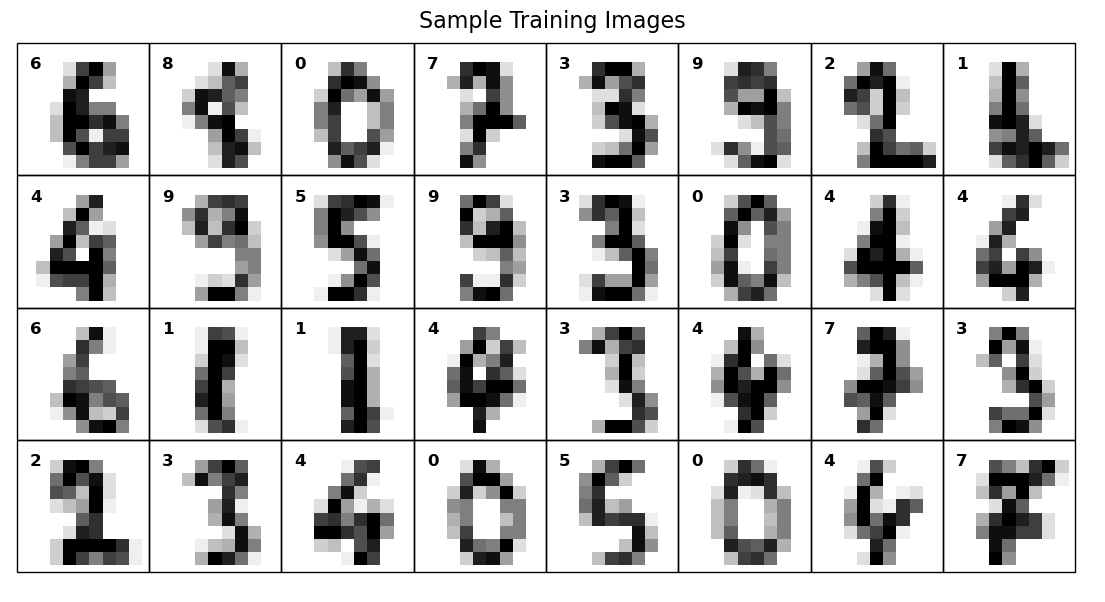

In [3]:
# Set the RNG seed to ensure reproducibility
torch.manual_seed(0)

# Load the (test set of the) UCI ML hand-written digits datasets
digits = load_digits()

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.2, random_state=0)

# Create PyTorch DataLoader for the training set
trainset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Create PyTorch DataLoader for the test set
testset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
testloader = DataLoader(testset, batch_size=32, shuffle=False)


# VISUALIZATION: show one training batch of images in a grid
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(make_grid(images.unsqueeze(1))[0].numpy(), cmap="gray_r")
for idx, (image, label) in enumerate(zip(images, labels)):
    x, y = 10 * (idx % 8), 10 * (idx // 8)
    ax.add_patch(plt.Rectangle((x, y), 10, 10, edgecolor="black", fill=False))
    ax.text(x + 1, y + 2, str(label.item()), fontsize=12, weight="bold")
ax.axis("off")
ax.set_title("Sample Training Images", fontsize=16)
plt.show()

Are the digits more readable now? Compare these images with the images from the previous notebook. It's hard to say if there's a noticeable improvement. Still, one might argue that the nuance with the grayscale value helps distinguish numbers in some instances. For example, take the 2 in the top row. Previously, it might be hard to say what the digit is. One might see it as a 1, 2, or a 9. The grayscale images make it a bit clearer that it's a 2. Let's see how the neural network fares. We'll use the functions we talked about above to create and train a neural network with the same architecture as before. But this time, we'll use these grayscale images rather than binary ones. We'll also plot the mean-squared error loss value for each epoch and then the final accuracy on the test data.

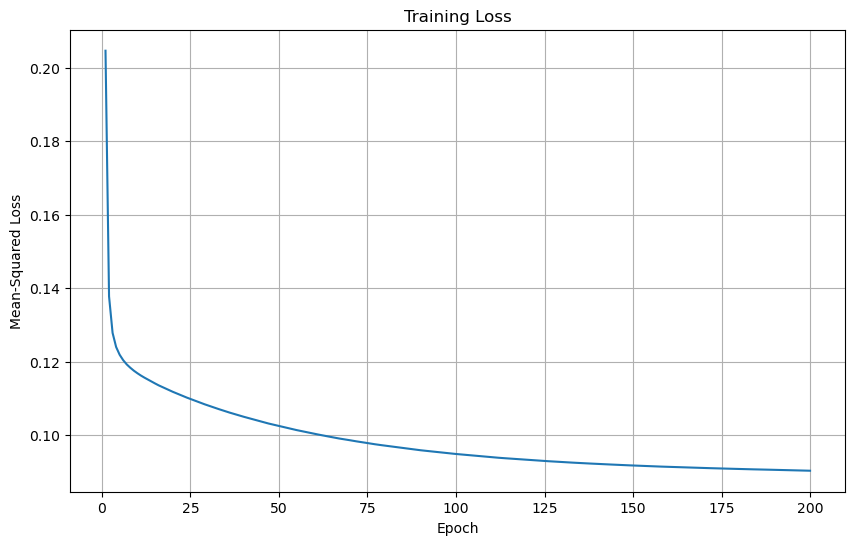

Accuracy of the network on the 360 test images: 10 %


In [4]:
# Reconstruct our neural network with 8 neurons per hidden layer
net = create_simple_nn(8 * 8, 8)

# Train the network as before, with mean-squared error as the loss function and using
# standard stochastic gradient descent
training_losses = train_model(net, trainloader, nn.MSELoss(), optim.SGD(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean-Squared Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the test set
test_accuracy = calculate_accuracy(net, testloader)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

10% is not an improvement from the 14% we saw previously. In fact, it's statistically equivalent to just guessing at random for each image. Perhaps we need to explore a different avenue.

## Making the Network Bigger

Next, we'll increase the *capacity* of the neural network. In other words, we'll make it bigger. Most modern neural networks are magnitudes of order larger than the one we have here. Our model currently has less than 1000 parameters. Models such as ChatGPT likely have billions to trillions of parameters. Of course, they also train for a much harder task than our network. Regardless, might our network improve if we make it a bit bigger? We'll increase the number of neurons in each hidden layer from 8 to 16.

In [5]:
# Reconstruct our neural network, but with 16 neurons per hidden layer this time
net = create_simple_nn(8 * 8, 16)


# VISUALIZATION: show the weights of the network
summary(net, (32, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]           1,040
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 16]             272
              ReLU-4                   [-1, 16]               0
            Linear-5                   [-1, 10]             170
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


We've doubled the number of neurons per hidden layer, resulting in slightly more than double the number of parameters. Let's see how this network performs on the binary image data set.

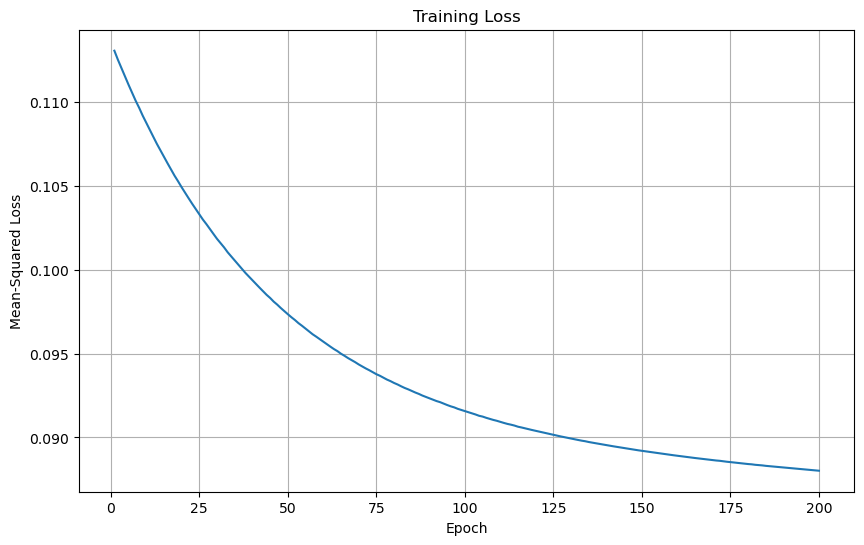

Accuracy of the network on the 360 test images: 21 %


In [6]:
# Create a new training/test split for binary images
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(digits.images >= 8, digits.target, test_size=0.2, random_state=0)

# Create a new PyTorch DataLoader for the binary images training set
trainset_bin = TensorDataset(torch.tensor(X_train_bin), torch.tensor(y_train_bin))
trainloader_bin = DataLoader(trainset_bin, batch_size=32, shuffle=True)

# Create a new PyTorch DataLoader for the binary images test set
testset_bin = TensorDataset(torch.tensor(X_test_bin), torch.tensor(y_test_bin))
testloader_bin = DataLoader(testset_bin, batch_size=32, shuffle=False)


# Train the bigger network on the binary images data set
training_losses = train_model(net, trainloader_bin, nn.MSELoss(), optim.SGD(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean-Squared Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the test set
test_accuracy = calculate_accuracy(net, testloader_bin)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

21%! Now, we see some improvement. Our previous model was *underfitting*. Because there were not enough parameters in our model, it couldn't learn an adequate relationship between the images and the labels. Now that we've increased the model's capacity, its ability to capture these relationships is improved. Let's give this larger model a chance to look at the grayscale images and see how it does on that.

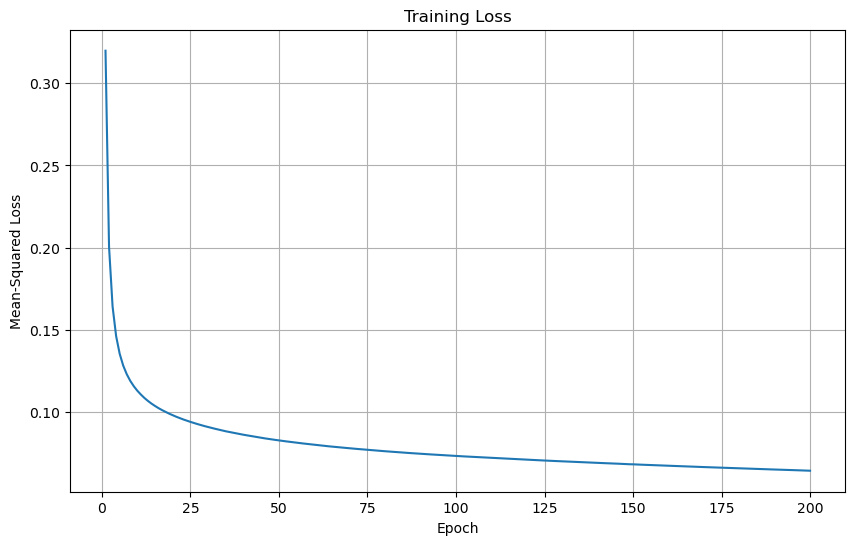

Accuracy of the network on the 360 test images: 59 %


In [7]:
# Reconstruct our neural network with 16 neurons per hidden layer
net = create_simple_nn(8 * 8, 16)

# Train the network on the grayscale images data set
training_losses = train_model(net, trainloader, nn.MSELoss(), optim.SGD(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean-Squared Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the test set
test_accuracy = calculate_accuracy(net, testloader)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

59%! What an improvement! This model now gets a passing grade. Where did this improvement come from? Our performance worsened when we tried the grayscale data set on the previous model. But now, with the larger model, we see a fantastic improvement. This is where the difficulty of *tuning* neural networks comes in. Neural networks have many different knobs and levers one might adjust to look for a performance gain. However, it isn't as simple as disregarding one knob just because it resulted in a performance loss one time. These parameters of the training process itself, called *hyperparameters*, are related in a very complex way. And because there are so many different hyperparameters to tune, it's impossible to try out every combination. For example, we didn't try out 15 neurons per hidden layer. That could improve the model's performance. What if we added another hidden layer? What if we varied the number of neurons per hidden layer so they didn't all have to be identical?

We saw here that just because the grayscale data set didn't work for the smaller network, it doesn't mean that it's not worth trying. One hypothesis that might explain this is that the smaller model struggled especially hard with learning anything because the images are now more complex (not just 1s and 0s, but decimal values). However, now that we have a bigger network, it is more capable of using this information.

Let's visualize the weight matrices for some of this model's layers and also look at the activation values for an image.

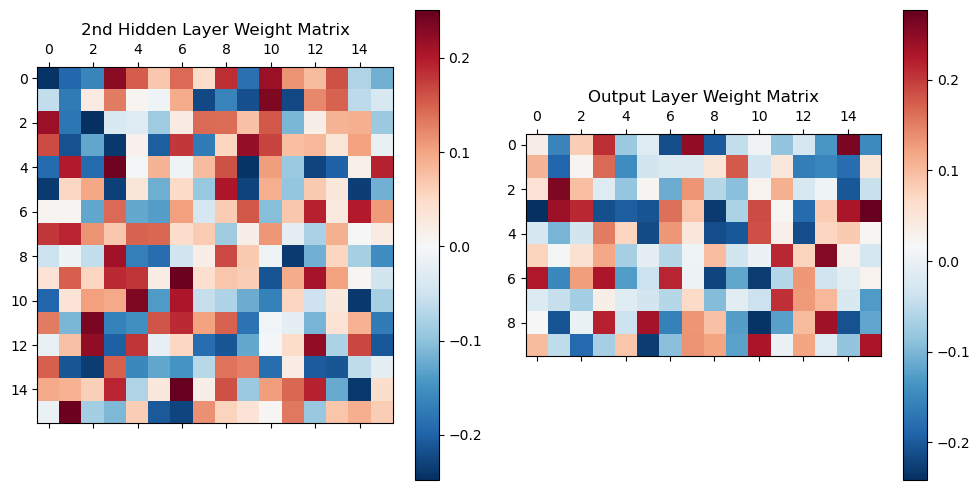

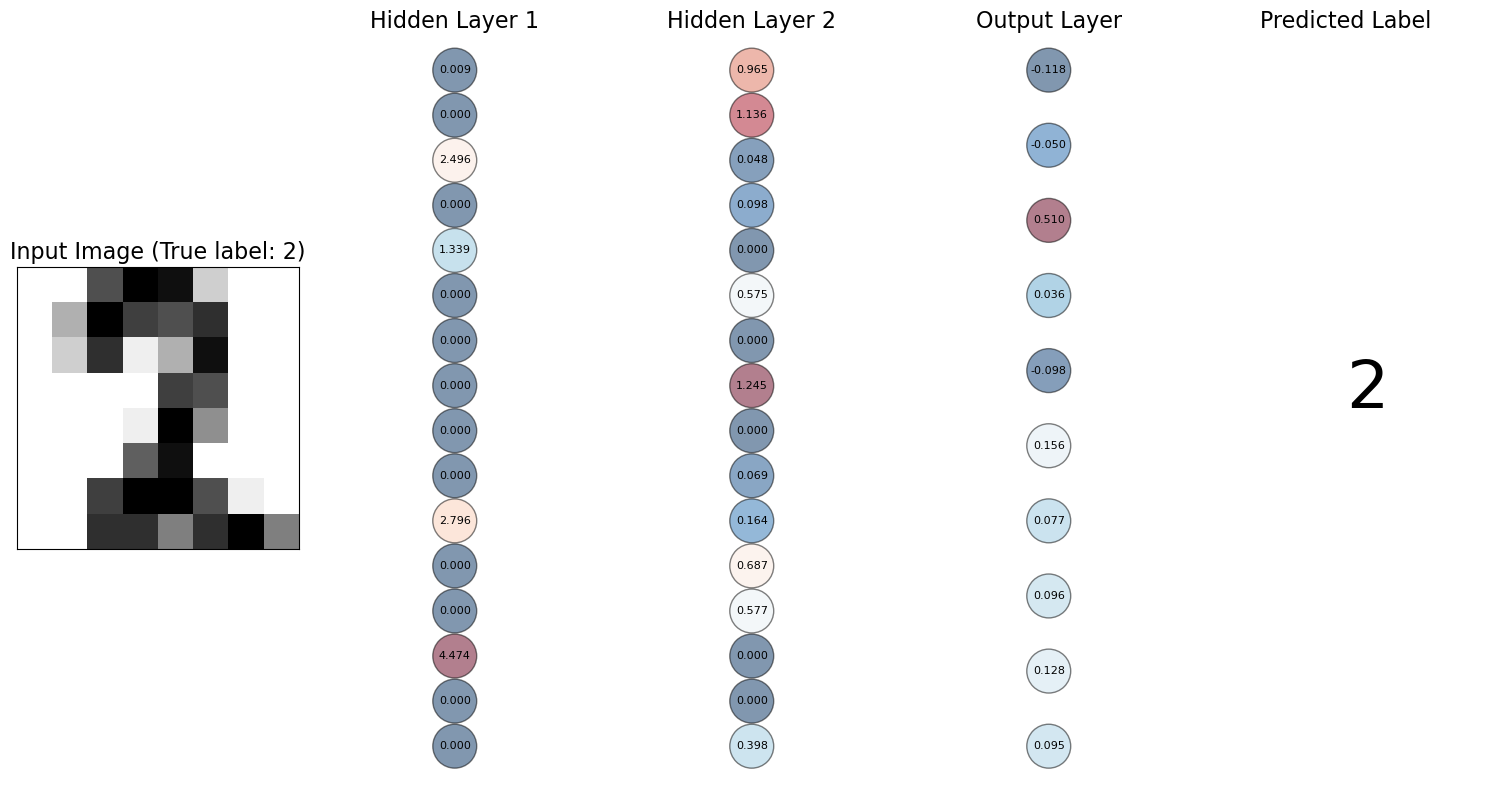

In [8]:
# Visualize the weight matrices for the last two layers of the network
visualize_weight_matrices(net)

# Visualize the activation values of each node for a random test example
visualize_network_activations(net, testloader)

Again, the weight matrices are near-impossible to diagnose. At the very least, the weights are not all collapsing the same value or something, but there isn't a particular pattern to observe. Looking at weight matrices to explain neural networks is exceptionally situationally useful.

The activation values for the network also exhibit a similar pattern to before, except that there are more neurons. One change is that the magnitude of the activations is generally larger. However, the number of nonzero activations at any given time is still lower than the total number of neurons. Another key change is in the values found in the output layer. Note that the activation value for 2 is 0.510. Before, the network's largest output value was 0.161, and this prediction wasn't even correct. This can be interpreted as the network being correct more often and more confident in its predictions. Let's take a closer look at these predictions by plotting the confusion matrix for this neural network model.

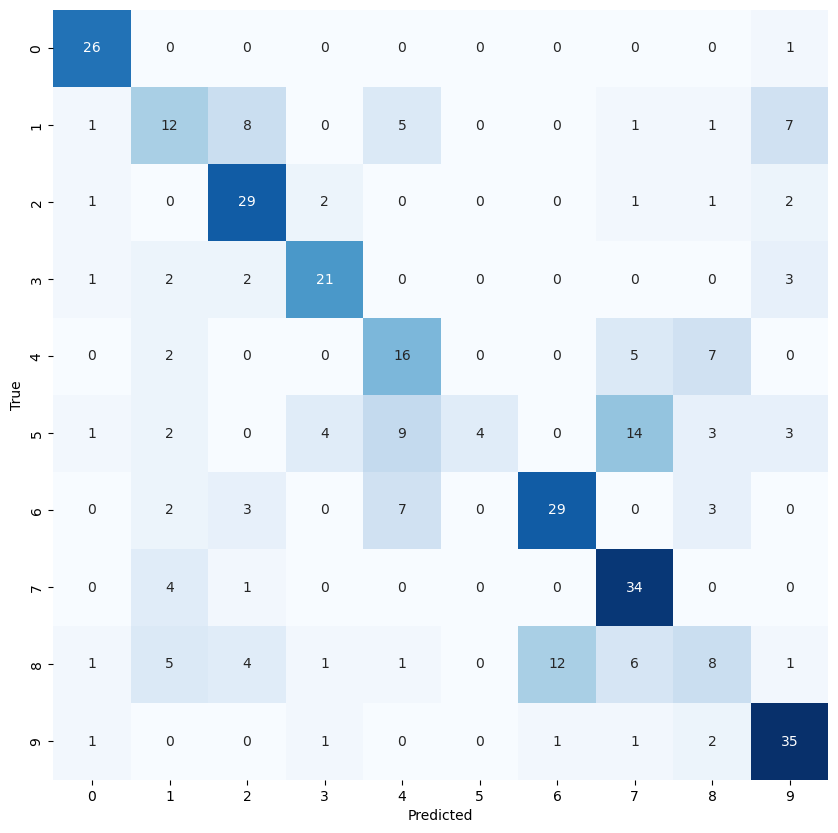

In [9]:
# VISUALIZATION: visualize a confusion matrix for the network
plot_confusion_matrix(net, testloader)

Recall that we previously mentioned that we wanted to see a diagonal matrix, which would correspond to perfect classification. We don't quite get that here, but it's much better than before. Across most digits, the model classifies most examples for that digit correctly. It struggles with 5s and 8s, however. For 5s, it confuses them with 7s, and for 8s, it confuses them with 6s.

For 5, the model's precision is quite good. Good precision here refers to the fact that the model is usually correct when the model predicts a 5. In fact, it's 100% correct in this case. However, the recall for 5 could be better. Poor recall refers to the fact that most of the 5s in the data set are not being identified as such. Precision and recall are more nuanced measures than accuracy and are quantifiable. For simplicity, we'll stick with accuracy in this notebook. However, if you go to build your own classification models, it's important to consider these measures as well, in addition to accuracy.

## Changing the Loss Function

The loss or cost function defines the surface that we want to optimize. In other words, we want to find the network parameters that minimizes the loss value. However, since our model has well over 1000 parameters, we can't just calculate the global minimum analytically. Instead, we use a different approach called *gradient descent*. Effectively, we start at a random set of parameters, use a batch of training samples to calculate the gradient, and then shift the weights in the direction of the negative gradient (corresponding to a descent of the loss value). However, imagine that the surface we want to minimize is completely flat, except for a singular bowl somewhere. If we initialize the weights somewhere on the flat part of the surface, how are we going to find the minimum? Gradient descent will likely not help us here and we would instead need to repeatedly initialize the weights until we just happen to initialize somewhere on the bowl.

One option we have is to change the loss surface itself. We can do this in various ways. One way is to change the parameters of the model. We did this by increasing the number of neurons in each hidden layer. Another way is to change the loss function. The loss function defines the criteria by which we wish to optimize the network. Currently, we have been using *mean squared error*. This is calculated by taking the element-wise difference between the network's output and the desired output, squaring this difference, and then averaging the values over the output vector. Let's break down why this operation might make sense to use.

In our case, the desired output for the network is a vector, or a 10x1 matrix, where every element is 0 except for the element corresponding to the correct digit label. The value for this element should be 1. If the network's output is precisely this vector, the loss value would be 0. If the network's output is a vector with 1 in a different spot, the loss value would be 2. We can see that we'd like to minimize the loss value. Why do we take the difference? Conceptually, it's simple; we want to minimize how different the network's output is from the desired output. What about squaring the difference? Well, we don't care which direction this difference is. It doesn't matter to us if the target value is 0, -1 or +1. Instead, we only care that the magnitude of this difference is 1. So, couldn't we take this absolute value instead? Yes! In fact, let's try out using this loss function instead. This loss function is generally called *mean absolute error*, or *L1 loss*.

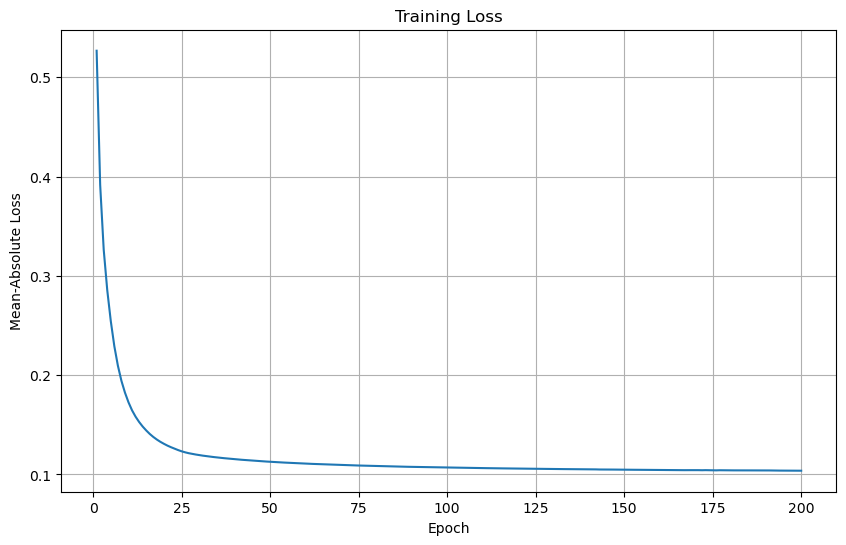

Accuracy of the network on the 360 test images: 10 %


In [10]:
# Reconstruct our neural network with 16 neurons per hidden layer
net = create_simple_nn(8 * 8, 16)

# Train the network on the grayscale images data set using mean absolute error
training_losses = train_model(net, trainloader, nn.L1Loss(), optim.SGD(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean-Absolute Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the test set
test_accuracy = calculate_accuracy(net, testloader)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

Our accuracy has plummeted to 9%, and we only changed by taking the absolute value of the difference rather than the square. So what makes the squared difference so much better? Well, now consider if the difference of one element was 2. The L1 loss would give us a value of 2, whereas the squared loss would give us a value of $2^2 = 4$. In other words, squared-error loss penalizes larger differences more. This generally helps the network steer towards making these larger, bolder predictions during training. However, as we cautioned, this does not mean L1 loss is never useful. If our target vectors were different or we changed some other hyperparameters of the model, we might find that L1 loss makes more sense. Finally, comparing loss values across different loss functions does not make sense. Since loss functions give different criteria to optimize, comparing their values is like comparing apples to oranges. Just because the loss value for one loss function is lower than that for another doesn't mean it's better.

Is there another loss function we might want to try? Yes, there's a loss function that's commonly used for classification tasks called *cross-entropy loss*. Cross-entropy is a concept taken from a field of mathematics called information theory. In brief, this loss function is particularly suited for classification tasks where we want to compare the difference between two probability distributions. The target vector for our classification tasks is a probability distribution: each element is between 0 and 1, and the sum of the vector is 1. If we normalize the network's output (i.e., divide each element by the sum of the vector), it too would be a probability distribution. The PyTorch implementation of cross-entropy does exactly that for us. So, let's see how this loss function is suited for classification tasks on our data set.

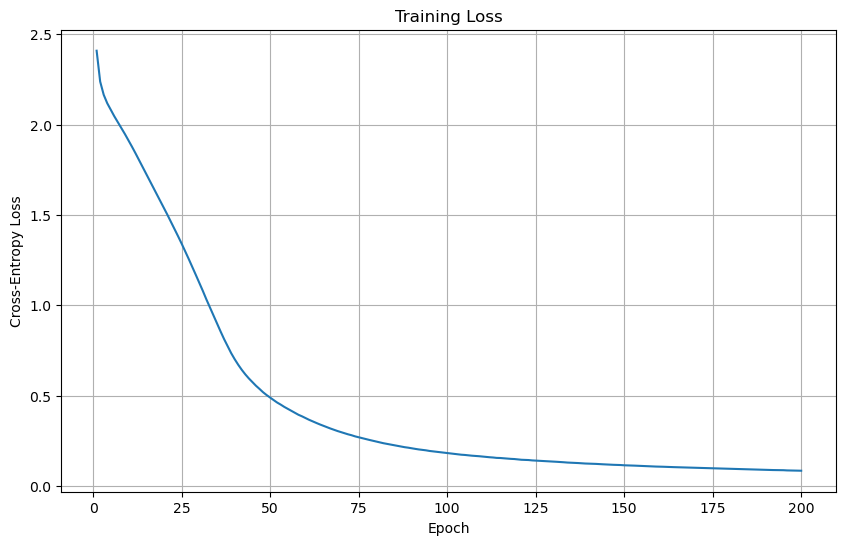

Accuracy of the network on the 360 test images: 95 %


In [11]:
# Reconstruct our neural network with 16 neurons per hidden layer
net = create_simple_nn(8 * 8, 16)

# Train the network on the grayscale images data set using cross-entropy loss
training_losses = train_model(net, trainloader, nn.CrossEntropyLoss(), optim.SGD(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the test set
test_accuracy = calculate_accuracy(net, testloader)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

With cross-entropy as our loss function, we achieved an incredible 95% accuracy on the test. This is an astonishing leap in performance, all achieved by effectively changing one line of code. Of course, the PyTorch library takes care of most of the work for us. However, it's important to note here how domain knowledge is invaluable in tuning neural networks and AI models in general. We've applied a concept from a different field of mathematics to our model.

Similarly, we might use domain knowledge to adjust the images in our model. For instance, changing the images slightly by rotating the digits by several degrees might make sense because not everyone writes them perfectly centred. At the same time, flipping the numbers upside-down might not make the most sense because many digits no longer make sense, and in fact, 6s become 9s and vice versa. However, flipping the images might make sense for other image data sets.

Let's take a quick look to see what our weight matrices and activation values look like.

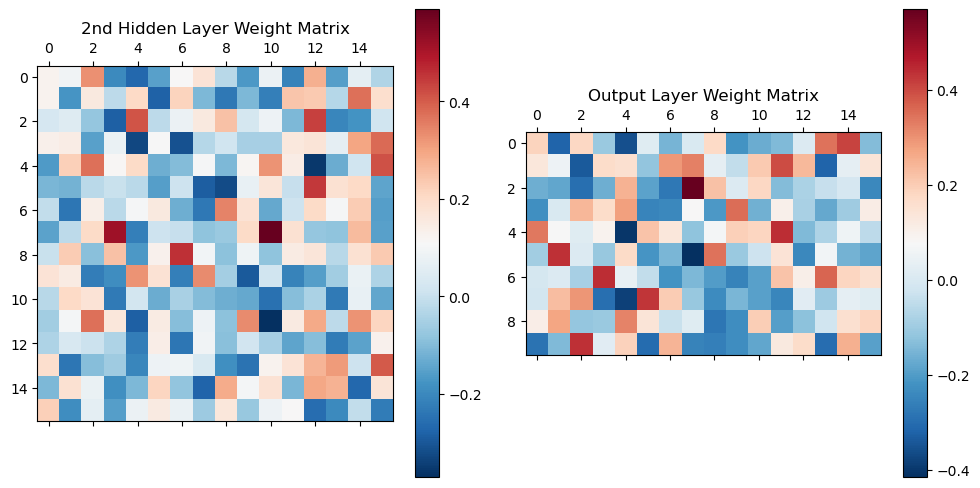

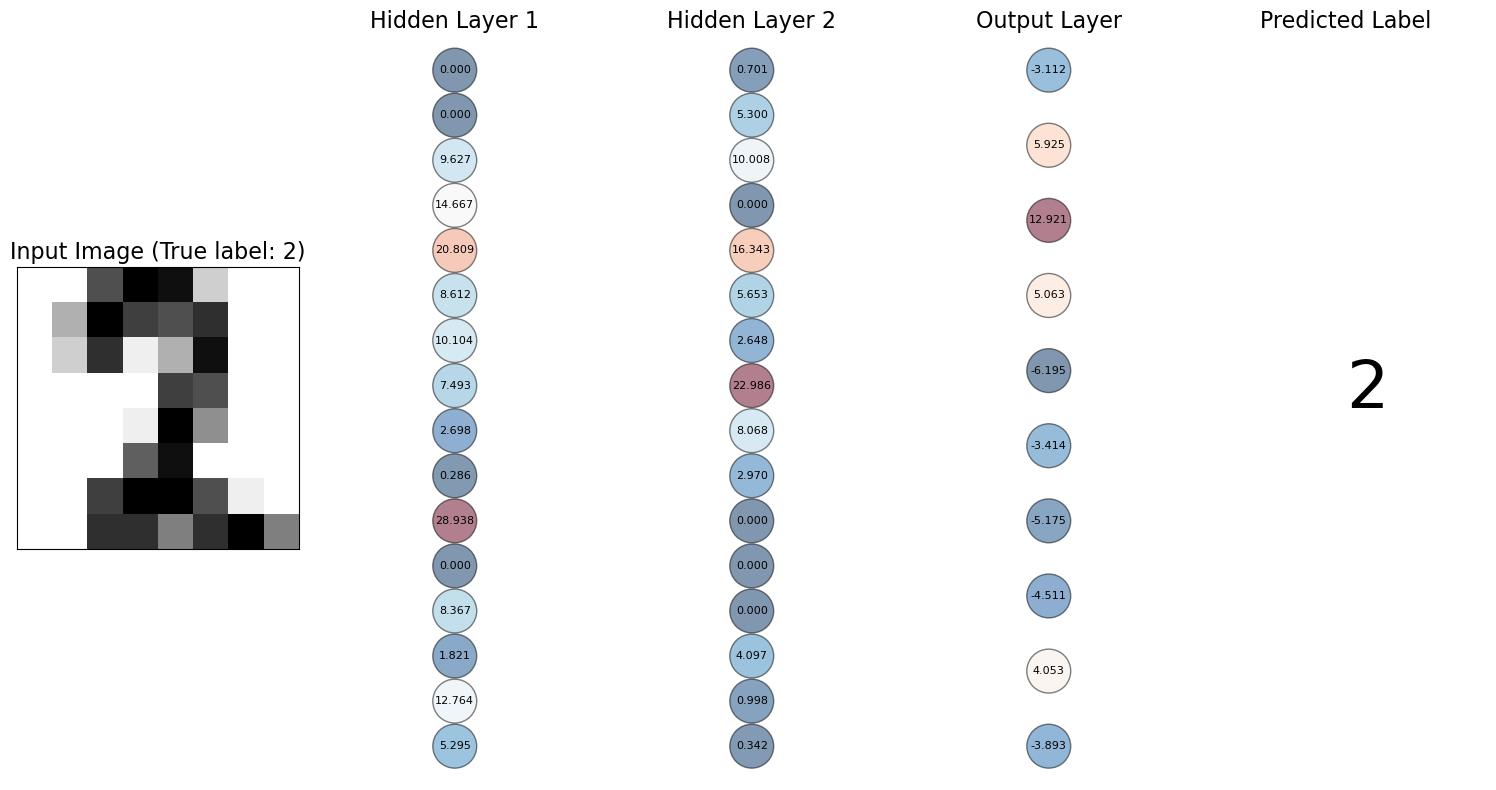

In [12]:
# Visualize the weight matrices for the last two layers of the network
visualize_weight_matrices(net)

# Visualize the activation values of each node for a random test example
visualize_network_activations(net, testloader)

Again, it's hard to tell anything from the weight matrices, but at least there's no glaring issue in them. If anything, perhaps the weights are more uniform now. But that may not be true, nor does it mean anything. We also see that our activation values are generally larger, and the network appears less sparse now (fewer 0 values in the activations). Again, this doesn't necessarily equate to a good thing. Still, it may be that the network is more effectively using its available neurons. Notice how the values in the output layer have changed now, thanks to the new loss function. The loss function takes care of the normalization for us, so they're not normalized yet.

Now, let's take a look at what the confusion matrix for our 95%-accurate model.

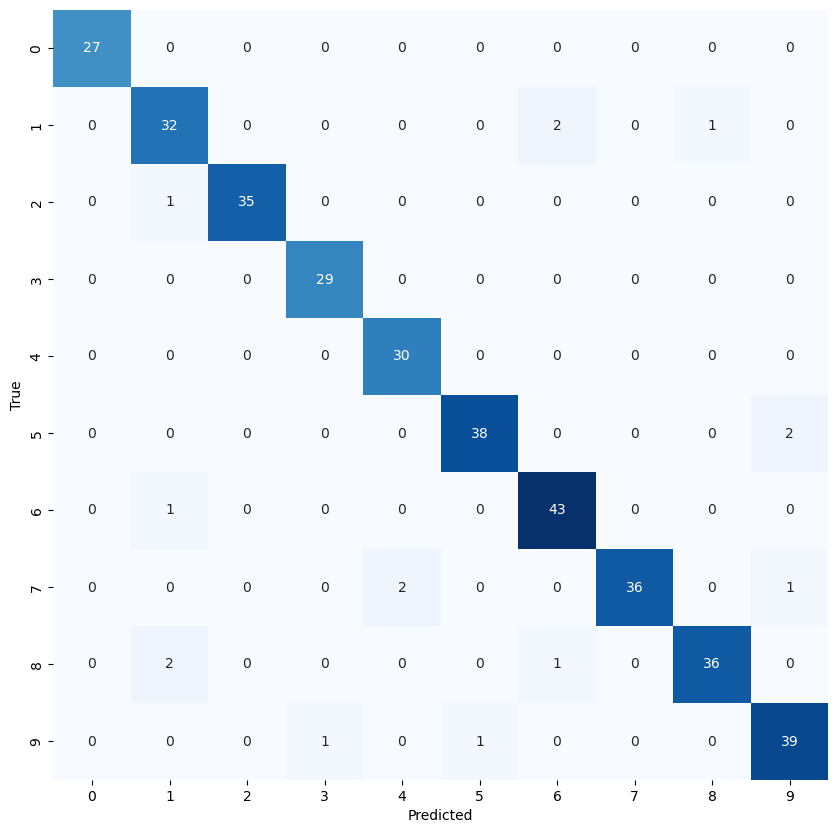

In [13]:
# VISUALIZATION: visualize a confusion matrix for the network
plot_confusion_matrix(net, testloader)

We can see that the matrix is now mostly diagonal. The network still makes a couple of mistakes, however. For instance, it incorrectly classifies a 1 as a 6 twice and as an 8 once. However, it has perfect accuracy for the digits 0, 3, and 4. Let's investigate some of these misclassifications. Below, we have some visualization code that will plot six examples of misclassified digits, along with the actual true and predicted labels. As usual, we won't really go into how the visualization code works, but we are effectively looping through the test set and picking out the first five misclassifications. We wrap our plotting code in a function, `plot_misclassified_images(net, dataloader)`, that takes the network `net` and the data `dataloader` as arguments.

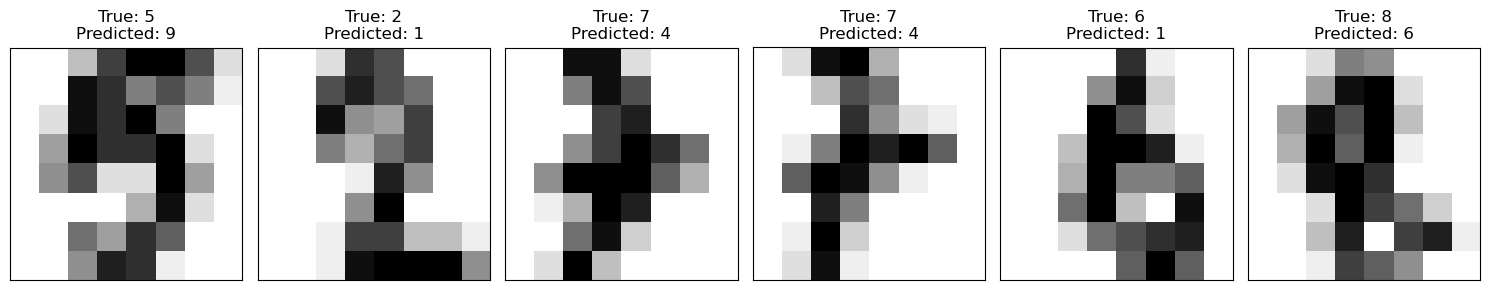

In [14]:
# VISUALIZATION: output 6 examples of misclassified images
def plot_misclassified_images(net, dataloader):
    fig, axs = plt.subplots(1, 6, figsize=(15, 5))
    i = 0

    for images, labels in dataloader:
        outputs = net(images.float())
        predicted = torch.argmax(outputs, 1)

        misclassified = predicted != labels
        for image, true_label, predicted_label in zip(images[misclassified], labels[misclassified], predicted[misclassified]):
            axs[i].imshow(image.numpy(), cmap="gray_r")
            axs[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            i += 1

            if i == 6:
                break
        if i == 6:
            break

    plt.tight_layout()
    plt.show()

plot_misclassified_images(net, testloader)

Truthfully, most of these would be difficult for a human to classify correctly. Particularly, it's rather hard to see that the middle image is that of a 7. While we haven't asked a sample of human volunteers to classify images for the test set, 95% is probably close to human accuracy. With difficult images such as these in the data set, can we get any better?

## Changing the Optimizer

Another thing we could change is how exactly we perform gradient descent. So far, we have done gradient descent by taking the gradient for a batch of the input data and taking a step in the direction of the negative gradient. This step effectively moves us downhill on the loss surface toward a minimum. But how big of a step should we take? If we take big steps, we might overshoot the minimum. If we take small steps, we might take too long to make progress. The exact size of a step we take is dictated by the *learning rate* parameter of the optimizer, which we have so far left at the default value of 0.001. We could adjust this value and try out different learning rates.

We could also modify our strategy. For example, let's consider the optimization problem as a ball rolling down a hill. The ball will not move at a constant rate down the hill. It will accelerate due to gravity. The analogous concept in optimization is *momentum*, and we can add this momentum to our optimizer. We might also try more complex ideas for adding more detail to the gradient descent step. A common algorithm used in machine learning optimization is called *Adam*. The details are well beyond the scope of this notebook. It is, in essence, modifying the gradient descent step to help the network locate a good local minimum. It is implemented in PyTorch, and below, we train the neural network from before using this new optimizer.

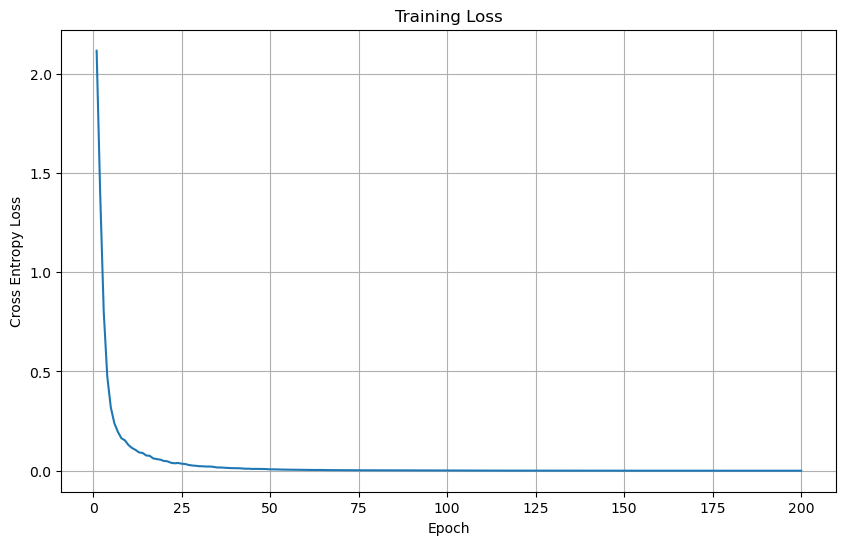

Accuracy of the network on the 360 test images: 98 %


In [15]:
# Reconstruct our neural network with 16 neurons per hidden layer
net = create_simple_nn(8 * 8, 16)

# Train the network on the grayscale images data set
training_losses = train_model(net, trainloader, nn.CrossEntropyLoss(), optim.Adam(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the test set
test_accuracy = calculate_accuracy(net, testloader)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

Look at that! With this new optimizer, we've increased our accuracy up to 98% on the test set. To get any further would take some more fine-tuning of parameters. However, we have to be careful. If we tune too much to our test, it may be that our model happens to be very good on the test set data but not on other data. In other wise, our model fails to generalize. This could be catastrophic. For instance, imagine training a self-driving car on a road over and over until it can drive that road well. Then, you test out the car in one city, and it works fine, so you decide it is good to go. However, when customers from a different country with different types of roads and traffic buy and use your car, they get into an accident. You investigate, and it turns out the car had no idea what to do on these types of roads it has yet to see. Instead of learning how to drive in general, the car learned how to drive on the types of roads in your country.

This is a phenomenon known as *overfitting*. This is also why we may be OK with not finding the global minimum. Unless your data set contains every single possible instance of the data that the network will ever see, the global minimum might not correspond to the minimum that lets your model generalize the best. So, it may be that it's best to leave our model at 98% accuracy. It's not perfect, but we can let it make mistakes so long as, in general, the model's performance is satisfactory. What this threshold is will depend on how the model is used. For self-driving cars, we'd want the car's performance to be near perfect. In cases where it fails, we'd also want to include the proper overrides so that the human driver can take control.

But our model is just a digits classifier. Let's take a look at the confusion matrix for this model.

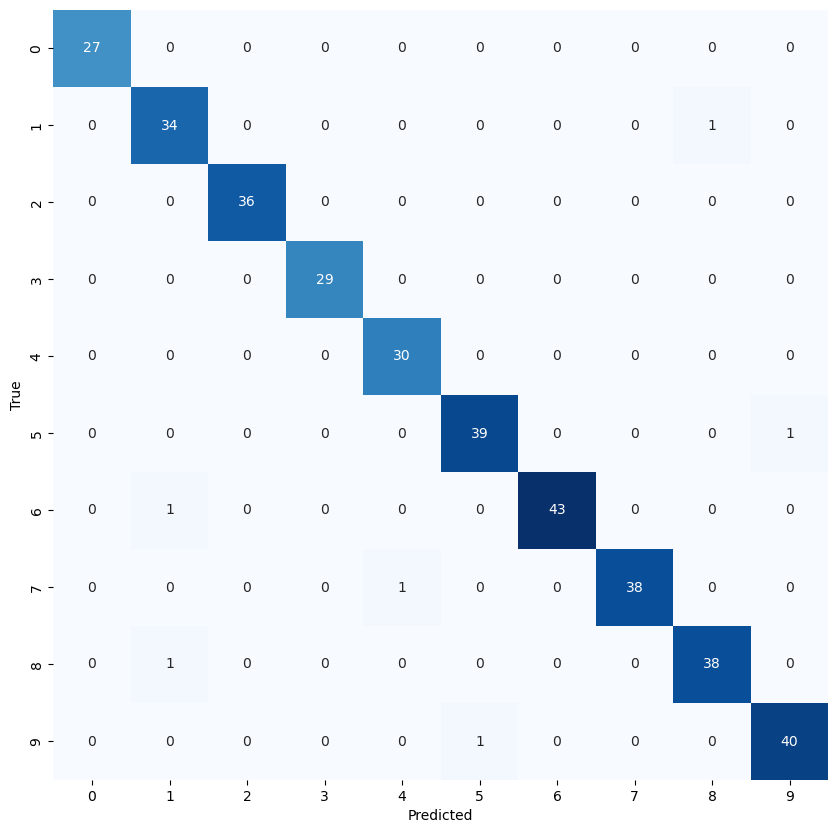

In [16]:
# VISUALIZATION: visualize a confusion matrix for the network
plot_confusion_matrix(net, testloader)

The model only make six mistakes now on the test set, which we visualize below.

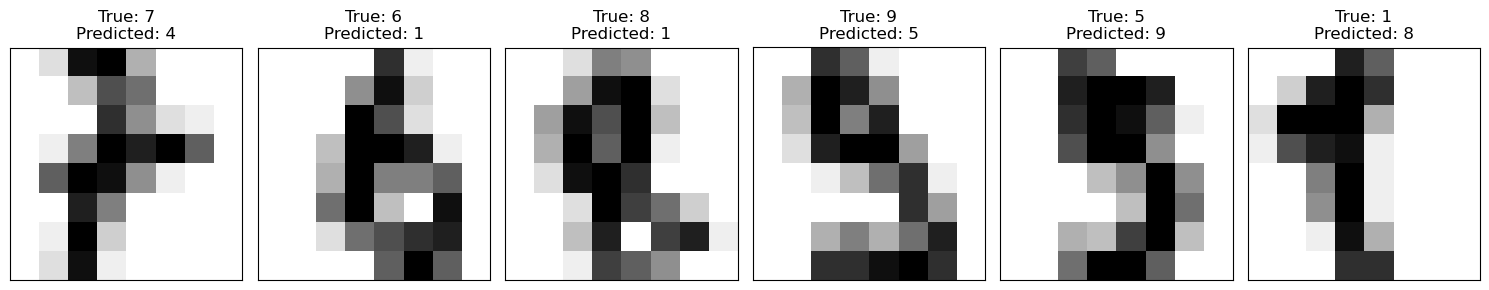

In [17]:
# VISUALIZATION: output 6 examples of misclassified images
plot_misclassified_images(net, testloader)

These images are challenging! Perhaps the 6 should be more obvious to the model, but the rest are difficult, even for humans. Visualizing the misclassifications is also useful for identifying mislabeled data. We don't have any in this data set, but ensuring the data set is completely correct is such a crucial step. Remember: garbage in, garbage. How can you expect it to learn if you provide the network with mislabeled data? Similarly, if you use biased data, such as for a text data set, the network will likely learn those biases. This is a big problem for language models like ChatGPT. It's not that neural networks are inherently untrustworthy algorithms. Indeed, they are near-impossible to interpret, but the data quality will likely have a greater influence on the model quality than the exact modelling algorithm itself.

Finally, out of curiosity, let's return to the original data set of images we used in the previous notebook. Recall that these images were not grayscale but instead binary. We'll use our new model and run the same visualization on this data set.

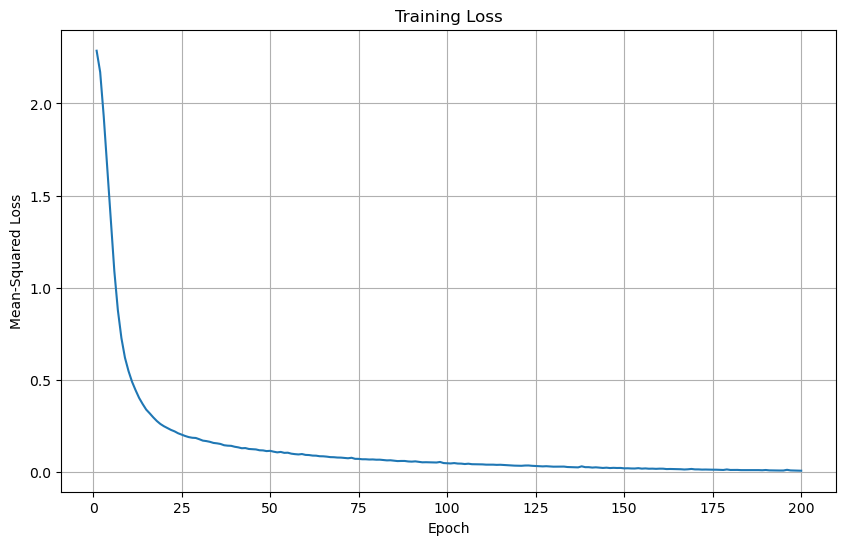

Accuracy of the network on the 360 test images: 90 %


In [18]:
# Reconstruct our neural network with 16 neurons per hidden layer
net = create_simple_nn(8 * 8, 16)

# Train the network on the binary images data set
training_losses = train_model(net, trainloader_bin, nn.CrossEntropyLoss(), optim.Adam(net.parameters(), lr=0.001))

# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), training_losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean-Squared Loss")
ax.grid(True)
plt.show()

# Display the neural network's accuracy on the binary images test set
test_accuracy = calculate_accuracy(net, testloader_bin)
print("Accuracy of the network on the 360 test images: %d %%" % test_accuracy)

The accuracy of the model is 90%. This is much better than the original 14% from the previous notebook. It's a bit worse than how the model did on the grayscale data set. Still, we sort of expected this since binarizing the images does lose some information that the network might be able to use. Let's look at the confusion matrix.

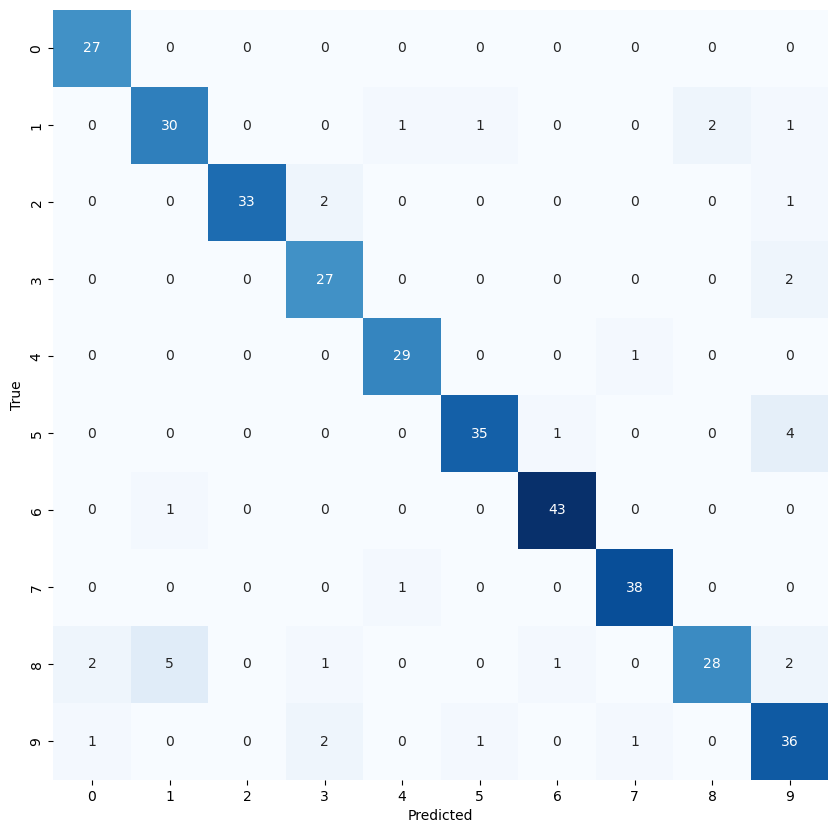

In [19]:
# VISUALIZATION: visualize a confusion matrix for the network
plot_confusion_matrix(net, testloader_bin)

Again, the matrix is mostly diagonal. There are a few larger spots of mistakes, such as the model mixing up an 8 as a 1 five times. But, overall, the number of misclassifications is low. Let's see some examples.

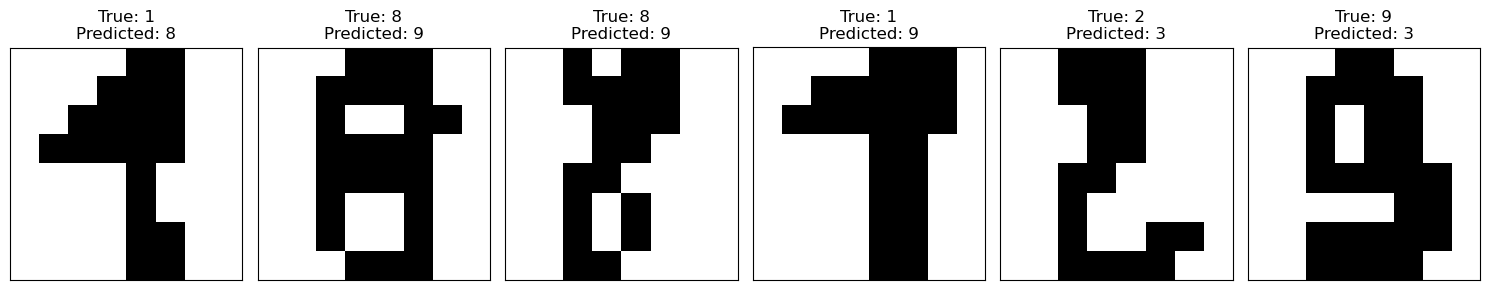

In [20]:
# VISUALIZATION: output 6 examples of misclassified images
plot_misclassified_images(net, testloader_bin)

As with before, some of these images are quite difficult to classify correctly, even for humans.

## Final Remarks

So, where do we go from here? As we mentioned previously, whether we are at a good point to stop depends on the use case for our model. Are we satisfied with the 98% accuracy on the test set? We may consider our data set too small to be confident in our model. In that case, our next step might be to extend our data set. We could collect more images to add to our data set. Alternatively, we might look to transform the images we already have—for example, a slight rotation of a couple of degrees to change each image slightly. Or we might randomly set some pixels in the image to white or black. These transformations aim to get our network to learn the general features of the digits rather than just memorizing what is in the data set.

We could also continue to try different things in our model. We could further increase the capacity of our model by adding more neurons per layer or by adding more layers. We could change the activation function we use in each neuron. We could train for more epochs or tune the parameters of the Adam optimizer. We could try a different loss function. We could also do further analysis by computing the precision and recall of our model, along with various other existing metrics. We could try a completely different machine learning approach, such as using decision trees or support vector machines, and compare our neural network to those approaches. We could also try other neural network approaches, such as convolutional neural networks. These networks are specifically suited for image data sets.

Ultimately, it's up to you to decide where to go from here. There are many different avenues to take, and not all of them will increase performance. But that doesn't mean it's not worth trying. There's still an art to building neural networks; sometimes, by playing around with different things, you'll end up stumbling onto the perfect solution.